# Toto: Zero-Shot Blood Glucose Forecasting

**Model**: Datadog/Toto-Open-Base-1.0 (151M parameters)  
**Dataset**: Kaggle BrisT1D  
**Task**: Nocturnal blood glucose forecasting (6 hours)

**Requirements:** `pip install toto-ts`

Toto is a time-series foundation model trained on 2T observability metrics. It provides probabilistic forecasts with uncertainty quantiles.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

from toto.model.toto import Toto
from toto.data.util.dataset import MaskedTimeseries
from toto.inference.forecaster import TotoForecaster

from src.data.diabetes_datasets.data_loader import get_loader
from src.data.models import ColumnNames
from src.utils.time_series_helper import get_interval_minutes
from src.data.preprocessing.time_processing import iter_daily_context_forecast_splits
from src.data.preprocessing.imputation import impute_missing_values

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


def compute_metrics(predictions, targets):
    """Compute RMSE, MAE, MAPE for forecast evaluation."""
    y_pred = np.asarray(predictions).flatten()
    y_true = np.asarray(targets).flatten()
    return {
        "rmse": float(root_mean_squared_error(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "mape": float(
            np.mean(np.abs((y_pred - y_true) / np.where(y_true != 0, y_true, 1e-8)))
            * 100
        ),
    }

/Users/alyss/Projects/UW/BGC/nocturnal-hypo-gly-prob-forecast/.venv/lib/python3.12/site-packages/lightning/fabric/__init__.py:40: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.


Device: cpu


In [2]:
# Configuration
INTERVAL_MINS = 5
NOCTURNAL_HOURS = 6
TARGET_COL = ColumnNames.BG.value

nocturnal_steps = int(NOCTURNAL_HOURS * 60 / INTERVAL_MINS)  # 72 steps
print(f"Predicting {nocturnal_steps} steps ({NOCTURNAL_HOURS} hours)")

Predicting 72 steps (6 hours)


In [3]:
# Load data and model
loader = get_loader(
    data_source_name="kaggle_brisT1D", dataset_type="train", use_cached=True
)
val_data = loader.validation_data

print("Loading Toto model...")
toto = Toto.from_pretrained("Datadog/Toto-Open-Base-1.0")
toto.to(device)
forecaster = TotoForecaster(toto.model)
print("Model loaded.")

2025-12-17T15:00:01 - ============================================================
2025-12-17T15:00:01 - Beginning data loading process with the following parmeters:
2025-12-17T15:00:01 - 	Dataset: kaggle_brisT1D - train
2025-12-17T15:00:01 - 	Columns: None
2025-12-17T15:00:01 - 	Generic patient start date: 2024-01-01 00:00:00
2025-12-17T15:00:01 - 	Number of validation days: 20
2025-12-17T15:00:01 - 	In parallel with up to 3 workers.

2025-12-17T15:00:01 - Loaded full processed data from cache for 9 patients
2025-12-17T15:00:02 - Loaded existing train/validation split from cache for 9 patients


Loading Toto model...
Model loaded.


In [4]:
def toto_forecast(
    context: np.ndarray,
    timestamps: pd.DatetimeIndex,
    prediction_length: int,
    num_samples: int = 100,
):
    """
    Run Toto forecast on univariate context.

    Returns: (median, q10, q90) prediction arrays
    """
    # Prepare input
    series = torch.tensor(context, dtype=torch.float32).unsqueeze(0).to(device)
    ts_seconds = (
        torch.tensor([ts.timestamp() for ts in timestamps], dtype=torch.float32)
        .unsqueeze(0)
        .to(device)
    )

    inputs = MaskedTimeseries(
        series=series,
        padding_mask=torch.ones_like(series, dtype=torch.bool),
        id_mask=torch.zeros_like(series),
        timestamp_seconds=ts_seconds,
        time_interval_seconds=torch.tensor(
            [INTERVAL_MINS * 60], dtype=torch.float32
        ).to(device),
    )

    # Forecast
    with torch.no_grad():
        forecast = forecaster.forecast(
            inputs,
            prediction_length=prediction_length,
            num_samples=num_samples,
            samples_per_batch=50,
        )

    return (
        forecast.median.cpu().numpy()[0],
        forecast.quantile(0.1).cpu().numpy()[0],
        forecast.quantile(0.9).cpu().numpy()[0],
    )

## Evaluation

Evaluate using day-split validation:
- **Context**: Daytime data (6am-midnight)
- **Target**: Nocturnal period (midnight-6am next day)

In [5]:
# Store per-day results for later visualization
day_results = []  # List of dicts with predictions, targets, context for each day

for patient_id, patient_df in val_data.items():
    if get_interval_minutes(patient_df) != INTERVAL_MINS:
        continue

    for daytime, nocturnal in iter_daily_context_forecast_splits(patient_df):
        context = daytime[TARGET_COL].values
        target = nocturnal[TARGET_COL].values[:nocturnal_steps]

        if np.isnan(context).any() or np.isnan(target).any():
            continue
        if len(context) < 10 or len(target) < nocturnal_steps:
            continue

        pred, q10, q90 = toto_forecast(context, daytime.index, nocturnal_steps)

        day_results.append(
            {
                "patient": patient_id,
                "context": context,
                "timestamps": daytime.index,
                "target": target,
                "pred": pred.flatten(),
                "q10": q10.flatten(),
                "q90": q90.flatten(),
                "daytime_df": daytime,  # Keep for multivariate
            }
        )

# Aggregate metrics by patient
patient_metrics = []
for pid in set(r["patient"] for r in day_results):
    patient_days = [r for r in day_results if r["patient"] == pid]
    preds = np.concatenate([r["pred"] for r in patient_days])
    targets = np.concatenate([r["target"] for r in patient_days])
    metrics = compute_metrics(preds, targets)
    patient_metrics.append(
        {
            "patient": pid,
            "rmse": metrics["rmse"],
            "mae": metrics["mae"],
            "days": len(patient_days),
        }
    )
    print(
        f"{pid}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f} ({len(patient_days)} days)"
    )

# Overall metrics
all_preds = np.concatenate([r["pred"] for r in day_results])
all_targets = np.concatenate([r["target"] for r in day_results])
overall = compute_metrics(all_preds, all_targets)
print(
    f"\nOverall: RMSE={overall['rmse']:.3f}, MAE={overall['mae']:.3f}, MAPE={overall['mape']:.1f}%"
)

p11: RMSE=2.463, MAE=1.931 (17 days)
p02: RMSE=3.353, MAE=2.552 (16 days)
p10: RMSE=1.474, MAE=1.081 (15 days)
p12: RMSE=2.986, MAE=2.214 (16 days)
p03: RMSE=4.163, MAE=2.967 (18 days)
p04: RMSE=2.059, MAE=1.513 (16 days)

Overall: RMSE=2.924, MAE=2.070, MAPE=25.7%


In [6]:
pd.DataFrame(patient_metrics)

,patient,rmse,mae,days
0,p11,2.462809,1.931413,17
1,p02,3.353029,2.551703,16
2,p10,1.473712,1.080629,15
3,p12,2.985853,2.214433,16
4,p03,4.163360,2.966596,18
5,p04,2.058925,1.512793,16


## Visualization

Example forecast with 80% prediction interval.

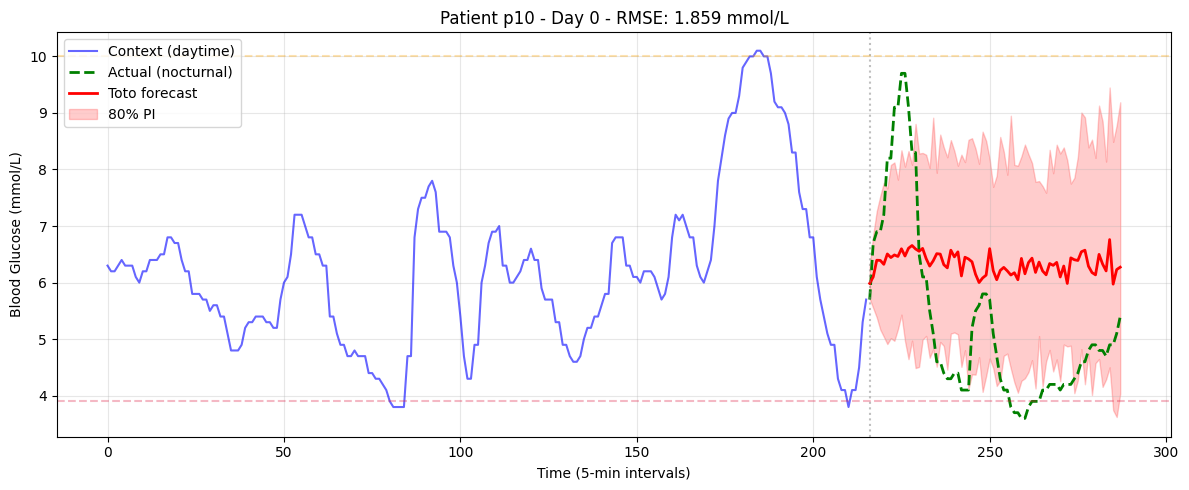

In [7]:
# Plot first valid day from stored results (no recomputation)
PATIENT = "p10"
patient_days = [r for r in day_results if r["patient"] == PATIENT]

if patient_days:
    day = patient_days[0]
    context, target, pred, q10, q90 = (
        day["context"],
        day["target"],
        day["pred"],
        day["q10"],
        day["q90"],
    )

    fig, ax = plt.subplots(figsize=(12, 5))
    t_ctx = np.arange(len(context))
    t_pred = np.arange(len(context), len(context) + len(target))

    ax.plot(t_ctx, context, "b-", alpha=0.6, label="Context (daytime)")
    ax.plot(t_pred, target, "g--", lw=2, label="Actual (nocturnal)")
    ax.plot(t_pred, pred, "r-", lw=2, label="Toto forecast")
    ax.fill_between(t_pred, q10, q90, alpha=0.2, color="red", label="80% PI")

    ax.axvline(len(context), color="gray", ls=":", alpha=0.5)
    ax.axhline(3.9, color="crimson", ls="--", alpha=0.3)
    ax.axhline(10.0, color="orange", ls="--", alpha=0.3)

    rmse = compute_metrics(pred, target)["rmse"]
    ax.set_title(f"Patient {PATIENT} - Day 0 - RMSE: {rmse:.3f} mmol/L")
    ax.set_xlabel("Time (5-min intervals)")
    ax.set_ylabel("Blood Glucose (mmol/L)")
    ax.legend()
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

---

## Multivariate Forecasting

Toto supports multivariate input. Here we add IOB, COB, steps, and calories as exogenous features.

In [8]:
EXOG_FEATURES = [
    ColumnNames.IOB.value,
    ColumnNames.COB.value,
    ColumnNames.STEPS.value,
    ColumnNames.CALS.value,
]
ALL_FEATURES = [TARGET_COL] + EXOG_FEATURES


def toto_forecast_multivariate(
    context_df: pd.DataFrame, prediction_length: int, num_samples: int = 100
):
    """
    Run Toto forecast with multivariate context.

    Args:
        context_df: DataFrame with columns [bg_mM, iob, cob, steps, cals]

    Returns: (median, q10, q90) for BG channel only
    """
    # Impute missing values using existing utility (linear interp for BG, constant for steps/cals)
    df = impute_missing_values(context_df[ALL_FEATURES].copy(), ALL_FEATURES)
    # Fallback for any remaining NaNs (IOB, COB not handled by impute_missing_values)
    df = df.ffill().bfill()

    context = df.values  # (timesteps, features)
    if np.isnan(context).any():
        return None, None, None

    # Prepare input: (features, timesteps)
    num_channels = len(ALL_FEATURES)
    series = torch.tensor(context.T, dtype=torch.float32).to(device)
    ts_seconds = (
        torch.tensor([ts.timestamp() for ts in context_df.index], dtype=torch.float32)
        .unsqueeze(0)
        .expand(num_channels, -1)
        .to(device)
    )

    inputs = MaskedTimeseries(
        series=series,
        padding_mask=torch.ones_like(series, dtype=torch.bool),
        id_mask=torch.zeros_like(series),
        timestamp_seconds=ts_seconds,
        time_interval_seconds=torch.full(
            (num_channels,), INTERVAL_MINS * 60, dtype=torch.float32
        ).to(device),
    )

    with torch.no_grad():
        forecast = forecaster.forecast(
            inputs,
            prediction_length=prediction_length,
            num_samples=num_samples,
            samples_per_batch=50,
        )

    # Extract BG channel (index 0)
    return (
        forecast.median.cpu().numpy()[0, 0],
        forecast.quantile(0.1).cpu().numpy()[0, 0],
        forecast.quantile(0.9).cpu().numpy()[0, 0],
    )

In [9]:
# Add multivariate predictions to existing day_results (reuses same days)
for day in day_results:
    daytime_df = day["daytime_df"]
    if not all(f in daytime_df.columns for f in ALL_FEATURES):
        day["pred_mv"], day["q10_mv"], day["q90_mv"] = None, None, None
        continue

    result = toto_forecast_multivariate(daytime_df, nocturnal_steps)
    if result[0] is not None:
        day["pred_mv"] = result[0].flatten()
        day["q10_mv"] = result[1].flatten()
        day["q90_mv"] = result[2].flatten()
    else:
        day["pred_mv"], day["q10_mv"], day["q90_mv"] = None, None, None

# Aggregate multivariate metrics
mv_results = [r for r in day_results if r.get("pred_mv") is not None]
patient_metrics_mv = []
for pid in set(r["patient"] for r in mv_results):
    patient_days = [r for r in mv_results if r["patient"] == pid]
    preds = np.concatenate([r["pred_mv"] for r in patient_days])
    targets = np.concatenate([r["target"] for r in patient_days])
    metrics = compute_metrics(preds, targets)
    patient_metrics_mv.append(
        {
            "patient": pid,
            "rmse": metrics["rmse"],
            "mae": metrics["mae"],
            "days": len(patient_days),
        }
    )
    print(
        f"{pid}: RMSE={metrics['rmse']:.3f}, MAE={metrics['mae']:.3f} ({len(patient_days)} days)"
    )

all_preds_mv = np.concatenate([r["pred_mv"] for r in mv_results])
all_targets_mv = np.concatenate([r["target"] for r in mv_results])
overall_mv = compute_metrics(all_preds_mv, all_targets_mv)
print(
    f"\nMultivariate Overall: RMSE={overall_mv['rmse']:.3f}, MAE={overall_mv['mae']:.3f}"
)

p11: RMSE=2.434, MAE=1.890 (17 days)
p02: RMSE=3.305, MAE=2.466 (16 days)
p10: RMSE=1.452, MAE=1.065 (15 days)
p12: RMSE=2.882, MAE=2.097 (16 days)
p03: RMSE=4.185, MAE=3.022 (18 days)
p04: RMSE=2.007, MAE=1.463 (16 days)

Multivariate Overall: RMSE=2.892, MAE=2.030


In [10]:
# Compare univariate vs multivariate
print("Univariate vs Multivariate Comparison")
print("=" * 40)
print(f"Univariate   RMSE: {overall['rmse']:.3f} mmol/L")
print(f"Multivariate RMSE: {overall_mv['rmse']:.3f} mmol/L")
improvement = (overall["rmse"] - overall_mv["rmse"]) / overall["rmse"] * 100
print(f"Improvement: {improvement:+.1f}%")

Univariate vs Multivariate Comparison
Univariate   RMSE: 2.924 mmol/L
Multivariate RMSE: 2.892 mmol/L
Improvement: +1.1%


## Notes

**Key observations:**
- Toto provides probabilistic forecasts with uncertainty quantiles
- Multivariate input (with IOB, COB, activity) shows modest improvement
- Model does NOT handle NaN internally - must impute or skip

**Potential improvements:**
- Fine-tune on diabetes data
- Experiment with context lengths
- Use uncertainty for hypoglycemia risk assessment

## All Days Visualization

Compare univariate vs multivariate forecasts across all validation days for a patient.

Patient p10: 15 valid days


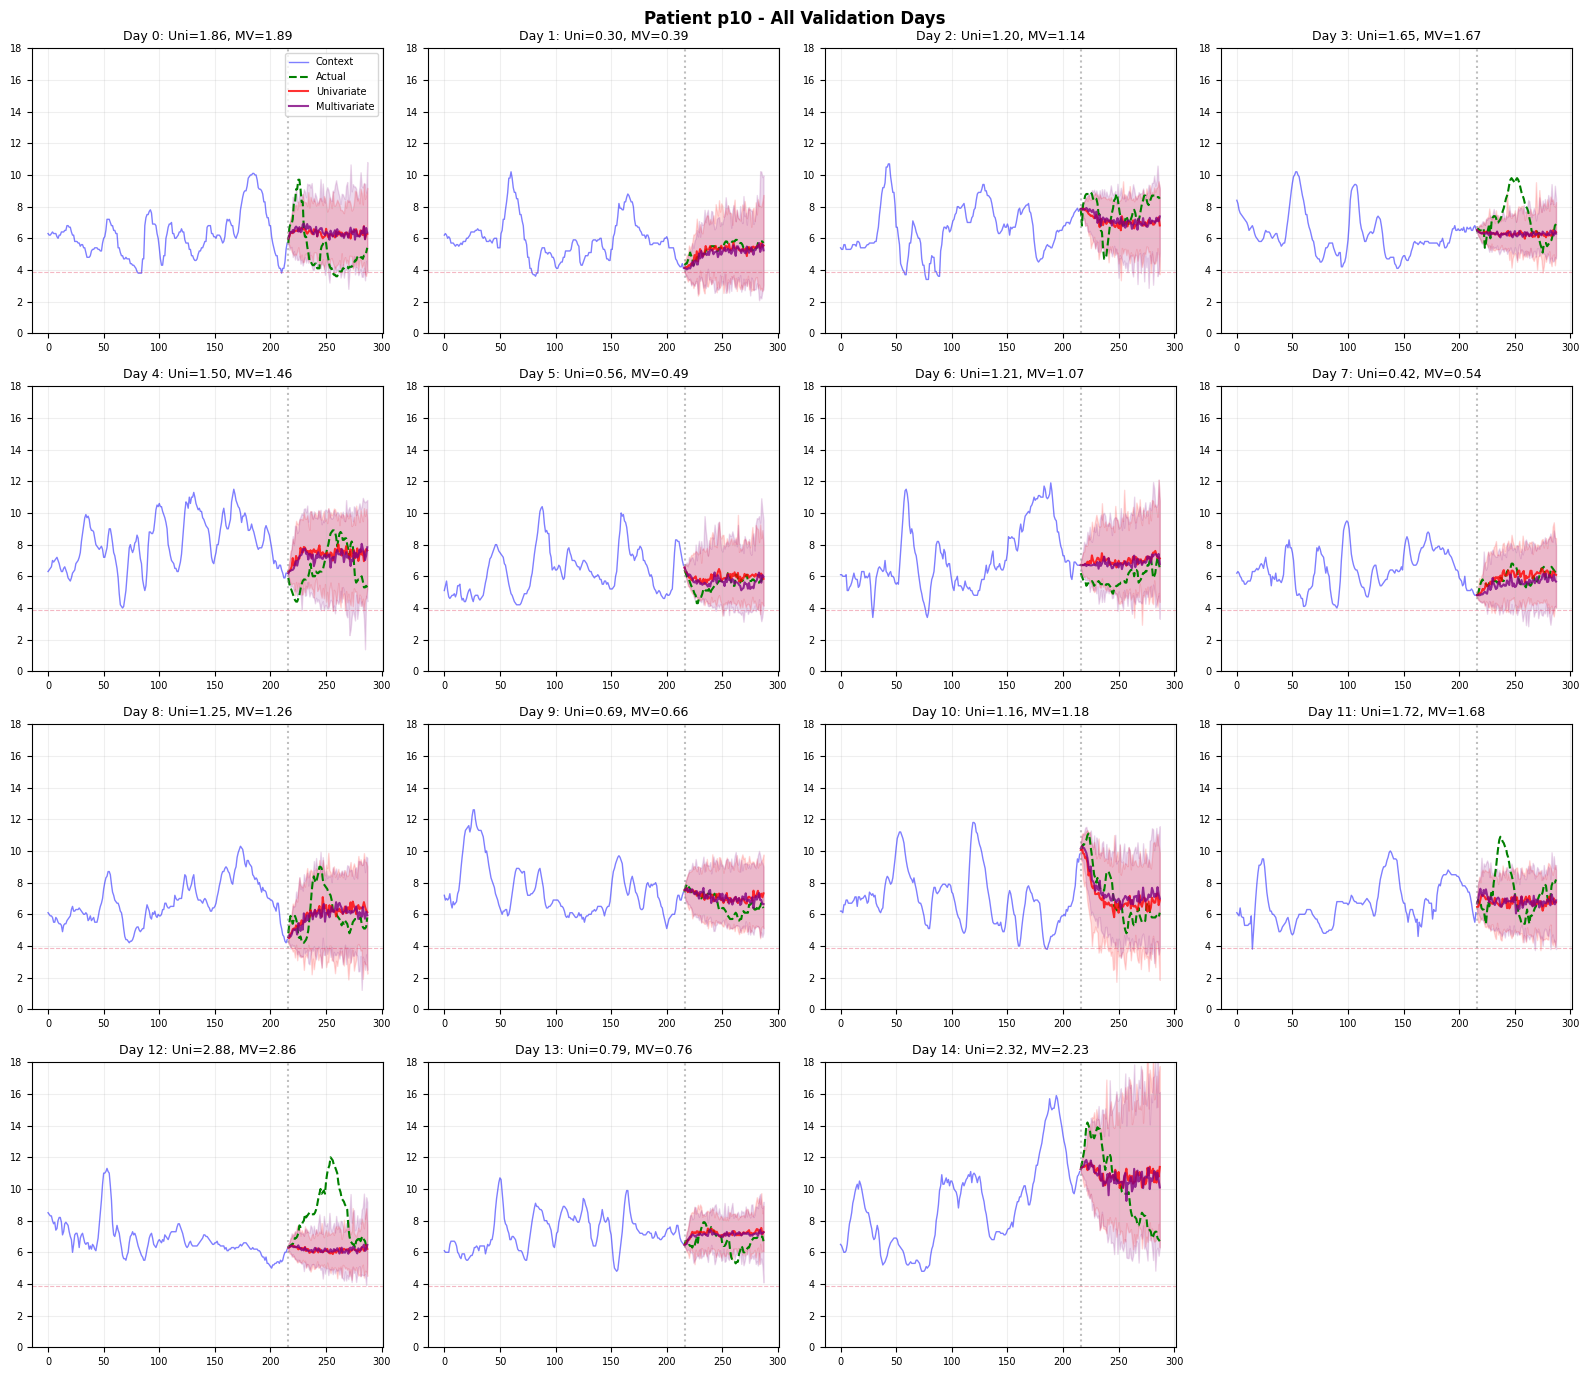

In [11]:
# Plot all days for a patient using stored results (no recomputation)
PLOT_PATIENT = "p10"
NCOLS = 4

patient_days = [r for r in day_results if r["patient"] == PLOT_PATIENT]
num_days = len(patient_days)
print(f"Patient {PLOT_PATIENT}: {num_days} valid days")

if num_days > 0:
    nrows = int(np.ceil(num_days / NCOLS))
    fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
    axes = np.array(axes).flatten() if num_days > 1 else [axes]

    for i, day in enumerate(patient_days):
        ax = axes[i]
        context, target = day["context"], day["target"]
        pred_uni, q10_uni, q90_uni = day["pred"], day["q10"], day["q90"]
        pred_mv, q10_mv, q90_mv = (
            day.get("pred_mv"),
            day.get("q10_mv"),
            day.get("q90_mv"),
        )

        t_ctx = np.arange(len(context))
        t_pred = np.arange(len(context), len(context) + len(target))

        ax.plot(t_ctx, context, "b-", alpha=0.5, lw=1, label="Context")
        ax.plot(t_pred, target, "g--", lw=1.5, label="Actual")
        ax.plot(t_pred, pred_uni, "r-", lw=1.5, alpha=0.8, label="Univariate")
        ax.fill_between(t_pred, q10_uni, q90_uni, alpha=0.15, color="red")

        if pred_mv is not None:
            ax.plot(t_pred, pred_mv, "purple", lw=1.5, alpha=0.8, label="Multivariate")
            ax.fill_between(t_pred, q10_mv, q90_mv, alpha=0.15, color="purple")

        ax.axvline(len(context), color="gray", ls=":", alpha=0.5)
        ax.axhline(3.9, color="crimson", ls="--", alpha=0.3, lw=0.8)

        rmse_uni = compute_metrics(pred_uni, target)["rmse"]
        title = f"Day {i}: Uni={rmse_uni:.2f}"
        if pred_mv is not None:
            rmse_mv = compute_metrics(pred_mv, target)["rmse"]
            title += f", MV={rmse_mv:.2f}"
        ax.set_title(title, fontsize=9)
        ax.set_ylim(0, 18)
        ax.tick_params(labelsize=7)
        ax.grid(alpha=0.2)

    for j in range(num_days, len(axes)):
        axes[j].set_visible(False)

    axes[0].legend(fontsize=7, loc="upper right")
    fig.suptitle(
        f"Patient {PLOT_PATIENT} - All Validation Days", fontsize=12, fontweight="bold"
    )
    plt.tight_layout()
    plt.show()

---

## Context Length Experiment

Research suggests foundation models may benefit from longer context windows (512-2048 steps). 
Current daytime-only context provides ~216 steps. Let's test if more history improves forecasting.

**Hypothesis**: Providing previous nocturnal periods in context may help predict the current night.

In [12]:
# Context lengths to test (in 5-min steps)
CONTEXT_LENGTHS = [216, 512, 1024, 2048]  # ~18h, ~42h, ~85h, ~170h


def evaluate_with_context_length(context_len: int) -> dict:
    """Evaluate forecasting with a fixed context length across all patients."""
    all_preds, all_targets = [], []

    for patient_id, patient_df in val_data.items():
        if get_interval_minutes(patient_df) != INTERVAL_MINS:
            continue

        # Get full patient data sorted by time
        df = patient_df.sort_index()
        if TARGET_COL not in df.columns:
            continue

        # Slide through data: for each nocturnal period, get preceding context
        for daytime, nocturnal in iter_daily_context_forecast_splits(df):
            target = nocturnal[TARGET_COL].values[:nocturnal_steps]
            if np.isnan(target).any() or len(target) < nocturnal_steps:
                continue

            # Get context_len steps ending at midnight (start of nocturnal)
            nocturnal_start = nocturnal.index[0]
            mask = df.index < nocturnal_start
            available = df.loc[mask, TARGET_COL].dropna()

            if len(available) < context_len:
                continue  # Not enough history

            context = available.iloc[-context_len:].values
            timestamps = available.iloc[-context_len:].index

            if np.isnan(context).any():
                continue

            pred, _, _ = toto_forecast(context, timestamps, nocturnal_steps)
            all_preds.append(pred.flatten())
            all_targets.append(target.flatten())

    if not all_preds:
        return {
            "context_len": context_len,
            "rmse": np.nan,
            "mae": np.nan,
            "n_samples": 0,
        }

    metrics = compute_metrics(np.concatenate(all_preds), np.concatenate(all_targets))
    return {
        "context_len": context_len,
        "hours": context_len * INTERVAL_MINS / 60,
        "rmse": metrics["rmse"],
        "mae": metrics["mae"],
        "n_samples": len(all_preds),
    }


# Run experiment
print("Testing context lengths...")
results = []
for ctx_len in CONTEXT_LENGTHS:
    print(
        f"  Context: {ctx_len} steps ({ctx_len * INTERVAL_MINS / 60:.0f} hours)...",
        end=" ",
    )
    result = evaluate_with_context_length(ctx_len)
    print(f"RMSE={result['rmse']:.3f} (n={result['n_samples']})")
    results.append(result)

context_df = pd.DataFrame(results)
context_df

Testing context lengths...
  Context: 216 steps (18 hours)... RMSE=2.857 (n=104)
  Context: 512 steps (43 hours)... RMSE=2.500 (n=99)
  Context: 1024 steps (85 hours)... RMSE=2.514 (n=92)
  Context: 2048 steps (171 hours)... RMSE=2.539 (n=73)


,context_len,hours,rmse,mae,n_samples
0,216,18.000000,2.856824,2.013088,104
1,512,42.666667,2.499517,1.839746,99
2,1024,85.333333,2.513546,1.810237,92
3,2048,170.666667,2.538971,1.826644,73


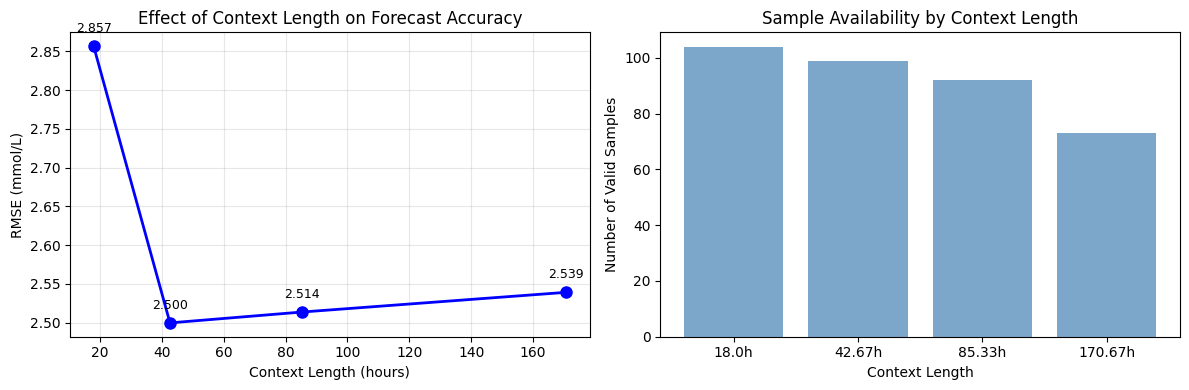


Best context length: 43 hours (512 steps)
Best RMSE: 2.500 mmol/L

Note: Longer contexts require more historical data, reducing valid samples.


In [13]:
# Visualize context length effect
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# RMSE by context length
ax = axes[0]
ax.plot(context_df["hours"], context_df["rmse"], "bo-", lw=2, markersize=8)
ax.set_xlabel("Context Length (hours)")
ax.set_ylabel("RMSE (mmol/L)")
ax.set_title("Effect of Context Length on Forecast Accuracy")
ax.grid(alpha=0.3)
for _, row in context_df.iterrows():
    ax.annotate(
        f"{row['rmse']:.3f}",
        (row["hours"], row["rmse"]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        fontsize=9,
    )

# Sample counts
ax = axes[1]
ax.bar(
    round(context_df["hours"], 2).astype(str) + "h",
    context_df["n_samples"],
    color="steelblue",
    alpha=0.7,
)
ax.set_xlabel("Context Length")
ax.set_ylabel("Number of Valid Samples")
ax.set_title("Sample Availability by Context Length")

plt.tight_layout()
plt.show()

# Summary
best = context_df.loc[context_df["rmse"].idxmin()]
print(
    f"\nBest context length: {best['hours']:.0f} hours ({best['context_len']:.0f} steps)"
)
print(f"Best RMSE: {best['rmse']:.3f} mmol/L")
print("\nNote: Longer contexts require more historical data, reducing valid samples.")

### Optimal Context Visualization

Compare forecasts using the default 18h context vs the optimal context length found above.

Patient p10: 15 days with 512-step history


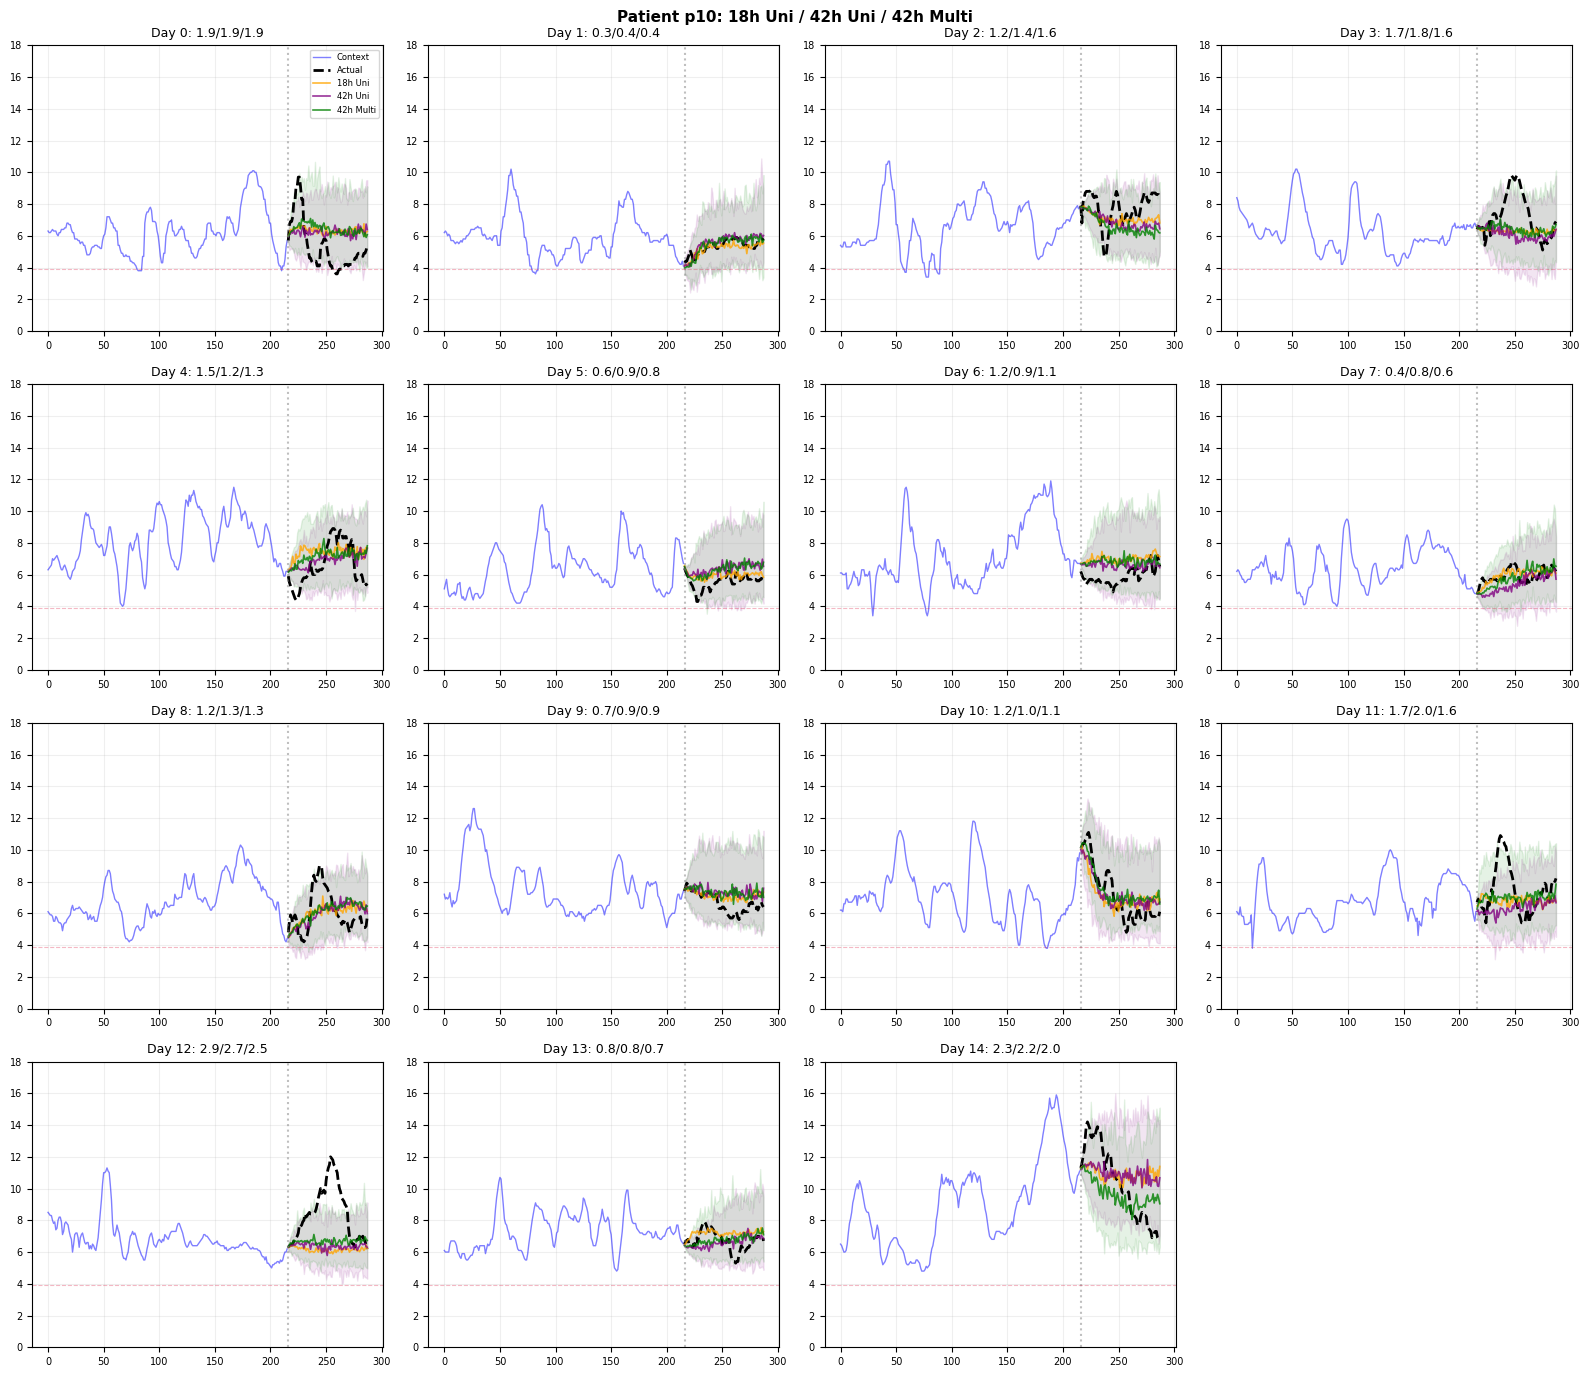


Approach             Avg RMSE  
------------------------------
18h Univariate       1.301
42h Univariate       1.344
42h Multivariate     1.278

Improvement over 18h: Ext Uni -3.3%, Ext Multi +1.7%


In [15]:
# Compare 18h (default) vs optimal context length (univariate & multivariate)
PLOT_PATIENT = "p10"
OPTIMAL_CONTEXT = int(context_df.loc[context_df["rmse"].idxmin(), "context_len"])
NCOLS = 4

patient_df = val_data[PLOT_PATIENT].sort_index()
patient_stored = [r for r in day_results if r["patient"] == PLOT_PATIENT]


# Helper for extended multivariate context
def get_extended_mv_context(patient_df, nocturnal_start, context_len):
    available = patient_df.loc[patient_df.index < nocturnal_start].dropna(
        subset=[TARGET_COL]
    )
    if len(available) < context_len:
        return None, None
    df = available.iloc[-context_len:][ALL_FEATURES].copy()
    df = impute_missing_values(df, ALL_FEATURES).ffill().bfill()
    return (df.values, df.index) if not df.isna().any().any() else (None, None)


def forecast_mv_extended(mv_context, mv_timestamps, pred_len):
    num_ch = len(ALL_FEATURES)
    series = torch.tensor(mv_context.T, dtype=torch.float32).to(device)
    ts_sec = (
        torch.tensor([t.timestamp() for t in mv_timestamps], dtype=torch.float32)
        .unsqueeze(0)
        .expand(num_ch, -1)
        .to(device)
    )
    inputs = MaskedTimeseries(
        series=series,
        padding_mask=torch.ones_like(series, dtype=torch.bool),
        id_mask=torch.zeros_like(series),
        timestamp_seconds=ts_sec,
        time_interval_seconds=torch.full(
            (num_ch,), INTERVAL_MINS * 60, dtype=torch.float32
        ).to(device),
    )
    with torch.no_grad():
        fc = forecaster.forecast(
            inputs, prediction_length=pred_len, num_samples=100, samples_per_batch=50
        )
    return (
        fc.median.cpu().numpy()[0, 0].flatten(),
        fc.quantile(0.1).cpu().numpy()[0, 0].flatten(),
        fc.quantile(0.9).cpu().numpy()[0, 0].flatten(),
    )


# Get days with enough history for optimal context
days_comparison = []
for i, day in enumerate(patient_stored):
    nocturnal_start = day["timestamps"][-1] + pd.Timedelta(minutes=INTERVAL_MINS)
    available = patient_df.loc[patient_df.index < nocturnal_start, TARGET_COL].dropna()

    if len(available) >= OPTIMAL_CONTEXT:
        days_comparison.append(
            {
                "idx": i,
                "target": day["target"],
                "pred_18h_uni": day["pred"],  # Already computed
                "nocturnal_start": nocturnal_start,
                "ext_context": available.iloc[-OPTIMAL_CONTEXT:].values,
                "ext_timestamps": available.iloc[-OPTIMAL_CONTEXT:].index,
                "display_context": day["context"],
            }
        )

print(
    f"Patient {PLOT_PATIENT}: {len(days_comparison)} days with {OPTIMAL_CONTEXT}-step history"
)

# Compute extended context predictions (univariate and multivariate)
for day in days_comparison:
    # Extended univariate
    pred, q10, q90 = toto_forecast(
        day["ext_context"], day["ext_timestamps"], nocturnal_steps
    )
    day["pred_ext_uni"], day["q10_ext_uni"], day["q90_ext_uni"] = (
        pred.flatten(),
        q10.flatten(),
        q90.flatten(),
    )

    # Extended multivariate
    mv_ctx, mv_ts = get_extended_mv_context(
        patient_df, day["nocturnal_start"], OPTIMAL_CONTEXT
    )
    if mv_ctx is not None:
        pred, q10, q90 = forecast_mv_extended(mv_ctx, mv_ts, nocturnal_steps)
        day["pred_ext_mv"], day["q10_ext_mv"], day["q90_ext_mv"] = pred, q10, q90
    else:
        day["pred_ext_mv"] = None

# Plot comparison
num_days = len(days_comparison)
nrows = int(np.ceil(num_days / NCOLS))
fig, axes = plt.subplots(nrows, NCOLS, figsize=(4 * NCOLS, 3.5 * nrows))
axes = np.array(axes).flatten() if num_days > 1 else [axes]

results = []
for i, day in enumerate(days_comparison):
    ax = axes[i]
    ctx, target = day["display_context"], day["target"]
    t_ctx = np.arange(len(ctx))
    t_pred = np.arange(len(ctx), len(ctx) + len(target))

    ax.plot(t_ctx, ctx, "b-", alpha=0.5, lw=1, label="Context")
    ax.plot(t_pred, target, "k--", lw=2, label="Actual")
    ax.plot(t_pred, day["pred_18h_uni"], "orange", lw=1.2, alpha=0.8, label="18h Uni")
    ax.plot(
        t_pred,
        day["pred_ext_uni"],
        "purple",
        lw=1.2,
        alpha=0.8,
        label=f"{OPTIMAL_CONTEXT//12}h Uni",
    )
    ax.fill_between(
        t_pred, day["q10_ext_uni"], day["q90_ext_uni"], alpha=0.1, color="purple"
    )

    if day["pred_ext_mv"] is not None:
        ax.plot(
            t_pred,
            day["pred_ext_mv"],
            "green",
            lw=1.2,
            alpha=0.8,
            label=f"{OPTIMAL_CONTEXT//12}h Multi",
        )
        ax.fill_between(
            t_pred, day["q10_ext_mv"], day["q90_ext_mv"], alpha=0.1, color="green"
        )

    ax.axvline(len(ctx), color="gray", ls=":", alpha=0.5)
    ax.axhline(3.9, color="crimson", ls="--", alpha=0.3, lw=0.8)

    r = {
        "18h_uni": compute_metrics(day["pred_18h_uni"], target)["rmse"],
        "ext_uni": compute_metrics(day["pred_ext_uni"], target)["rmse"],
        "ext_mv": compute_metrics(day["pred_ext_mv"], target)["rmse"]
        if day["pred_ext_mv"] is not None
        else np.nan,
    }
    results.append(r)
    ax.set_title(
        f"Day {day['idx']}: {r['18h_uni']:.1f}/{r['ext_uni']:.1f}/{r['ext_mv']:.1f}",
        fontsize=9,
    )
    ax.set_ylim(0, 18)
    ax.tick_params(labelsize=7)
    ax.grid(alpha=0.2)

for j in range(num_days, len(axes)):
    axes[j].set_visible(False)

axes[0].legend(fontsize=6, loc="upper right")
fig.suptitle(
    f"Patient {PLOT_PATIENT}: 18h Uni / {OPTIMAL_CONTEXT//12}h Uni / {OPTIMAL_CONTEXT//12}h Multi",
    fontsize=11,
    fontweight="bold",
)
plt.tight_layout()
plt.show()

# Summary
df_results = pd.DataFrame(results)
print(f"\n{'Approach':<20} {'Avg RMSE':<10}")
print("-" * 30)
for col, name in [
    ("18h_uni", "18h Univariate"),
    ("ext_uni", f"{OPTIMAL_CONTEXT//12}h Univariate"),
    ("ext_mv", f"{OPTIMAL_CONTEXT//12}h Multivariate"),
]:
    print(f"{name:<20} {df_results[col].mean():.3f}")
baseline = df_results["18h_uni"].mean()
print(
    f"\nImprovement over 18h: Ext Uni {(baseline - df_results['ext_uni'].mean())/baseline*100:+.1f}%, Ext Multi {(baseline - df_results['ext_mv'].mean())/baseline*100:+.1f}%"
)